In [1]:
import os
from core.project import Project
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_BOREHOLE_LEGEND

In [2]:
from core.orm import Base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from utils.visual import legend_from_attributes # une legende par défaut devrait être charge si aucune n'est passée issue #113

In [3]:
pollutants = ['Chlorure', 'PCB_28', 'PCB_138', 'PCB_118', 'BTEX_tot', 'S_tot', 'PCB_tot', 'PCB_180', 'PCB_101',
              'PCB_153', 'PCB_52', 'MTBE', 'Pyr', 'Bnz', 'Alp_C6-C8', 'Toln', 'Pb', 'Bnz(ghi)peryl', 'CN_cplx',
              'Cr_VI', 'Cis-1.2-DCEn', 'Ar_C6-C7', 'Cd', 'Phenol', '1.2-DCE', 'CN_libre', 'Bnz(a)pyr', 'Cu', 
              'Bnz(k)flranth', 'Anthrc', 'C16-C21', '1.1-DCEn', 'Chloroforme', 'Styr', 'Ni', 'EOX', 'Naphta', 
              'DCM', '1.1-DCE', 'C5-C8', 'As', '1.1.2-TCE', 'Bnz(b)flranth', 'Cr', 'HC_tot_C10-C40', 'HAP_tot_EPA', 
              'Co', 'Phenanthr', 'CN_tot', 'C12-C16', 'TCEyn', '(cis.trans)-1.2-DCEn_tot', 'Alp_C5-C6', 'Chrys', 
              'Trans-1.2-DCEyl', '1.2-DCP', 'Ar_C7-C8', '1.1.1-TCE', 'Zn', 'Indeno(1.2.3-cd)pyr', 'Alp_C8-C10', 
              'Flranth', 'HC_tot_C10-C35', 'Acenaphtyl', 'C8-C10', 'Bnz(a)anthrc', 'Dibnz(ah)anthrc', 'Hg', 
              'Ar_C8-C10', 'C10-C12', 'C35-C40', 'P-M-Xyl', 'CVinyl', 'Acenaphtn', 'TetraCEyn', 'Xyl', 'C21-C35', 
              'TCM', 'O-Xyl']
legend_dict = legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND), ('borehole_type', DEFAULT_BOREHOLE_LEGEND)])

In [4]:
legend_dict.keys()

dict_keys(['lithology', 'borehole_type'])

In [5]:
db_name = './new_db.db'
if os.path.exists(db_name):
    os.remove(db_name)

In [6]:
# This should become a constructor of Project (use polymorphism)
def load(db_name, **kwargs):
    """ loads a project from a project database"""
    legend_dict = kwargs.pop('legend_dict', legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND)]))
    litho_lexicon = kwargs.pop('litho_lexicon', None)
    project_name = kwargs.pop('project_name', db_name.rstrip('.db'))
    verbose = kwargs.pop('verbose', False)
    
    engine = create_engine(f"sqlite:///{db_name}", echo=verbose)
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    session = Session()
    if verbose:
        print(f'legend_dict: {legend_dict}')
    p = Project(session, name=project_name, legend_dict=legend_dict, lexicon=litho_lexicon)
    p.refresh()
    session.close()
    return p

## Create a new project from an empty database

In [7]:
p = load(db_name, legend_dict=legend_dict, verbose=False)
#p.plot_3d( window_size=(800, 600))

/home/su530201/PycharmProjects/GSDMA/core/project.py:76: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship. (Background on this error at: https://sqlalche.me/e/14/qzyx)
  self.boreholes_orm = self.session.query(BoreholeOrm).all()
/home/su530201/PycharmProjects/GSDMA/core/project.py:76: SAWarning: relationship 'ComponentOrm.intervals' will c

In [8]:
from core.orm import BoreholeOrm, IntervalOrm, PositionOrm, ComponentOrm, LinkIntervalComponentOrm

In [9]:
# This function should be converted into a method of Project
def insert_borehole(project, bh_dict, verbose=True):
    bh_orm = BoreholeOrm(id=bh_dict['id'], date=bh_dict.pop('date', None), length=bh_dict.pop('length', None), diameter=bh_dict.pop('diameter', None))
    intv_id = project.find_next_id(IntervalOrm)
    bh_orm.intervals_values.update({intv_id: {'description' : "{'lithology': 'remblais'}; {'borehole_type': 'piezometer'}",
                                'interval_number': 0,
                                'top': PositionOrm(**bh_dict['top']),
                                'base': PositionOrm(**bh_dict['base'])}})
    
    component_id = project.find_next_id(ComponentOrm)
    new_component = ComponentOrm(id=component_id, description="{'type': 'borehole_type', 'value': 'piezometer'}")
    
    # TODO verify if component is already present
    project.session.add(new_component)
    
    link_dict = {(intv_id, component_id): {'extra_data': 'None'}}
    print(f'interval : {intv_id}, component: {component_id}')
    project.add_link_components_intervals(link_dict)
    
    component_id = project.find_next_id(ComponentOrm)
    new_component = ComponentOrm(id=component_id, description="{'type': 'lithology', 'value': 'remblai'}")
    
    # TODO verify if component is already present
    project.session.add(new_component)
    link_dict = {(intv_id, component_id): {'extra_data': 'None'}}
    print(f'interval : {intv_id}, component: {component_id}')
    project.add_link_components_intervals(link_dict)
    
    project.commit()
    project.add_borehole(bh_orm, verbose)

In [10]:
insert_borehole(p, {'id':'F201', 'borehole_type': 'piezometer', 'length': 1.8, 'diameter':0.1, 'top':{'middle': 101.32, 'x': 152890., 'y': 122596.}, 'base':{'middle': 100., 'x': 152890., 'y': 122596.}})

interval : 0, component: 0
Boreholes in the project :  0
interval : 0, component: 1
Boreholes in the project :  0
Boreholes in the project :  0
Boreholes in the project :  0
Borehole geometry created successfully !

F201  added


/home/su530201/.local/share/virtualenvs/GSDMA-tJb-HgI6/lib/python3.8/site-packages/pyvista/core/dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


In [11]:
# p.boreholes_3d[0].plot_log(repr_attribute='lithology', verbose=True)

In [12]:
p.update_legend_cmap(compute_all_attrib=True, verbose=True)

BLCMap for : lithology
---------------------------------------
|-> BH: F201
find_comp -in- True | 2 component(s), position(s) for lithology: [0], value(s): {0: 'remblai'}
find_comp -in- True | 2 component(s), position(s) for lithology: [0], value(s): {0: 'remblai'}

BLCMap - unique/bh3d: ['remblai'], unique_proj: ['remblai']

BLCMap | Decors: {0: Decor({'_colour': '#d3b798', 'width': 3, 'hatch': "'v'", 'component': Component({'lithology': 'remblai'})})}
BLCMap for : borehole_type
---------------------------------------
|-> BH: F201
find_comp -in- True | 2 component(s), position(s) for borehole_type: [1], value(s): {0: None, 1: 'piezometer'}
find_comp -in- True | 2 component(s), position(s) for borehole_type: [1], value(s): {0: None, 1: 'piezometer'}

BLCMap - unique/bh3d: ['piezometer'], unique_proj: ['piezometer']

BLCMap | Decors: {0: Decor({'_colour': '#888888', 'width': 3, 'component': Component({'borehole_type': 'piezometer'}), 'hatch': None})}


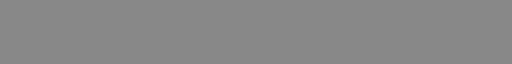

In [13]:
p.legend_dict['borehole_type']['cmap']

In [14]:
legend_dict['borehole_type']

{'legend': Legend(Decor({'_colour': '#888888', 'width': None, 'component': Component({'borehole_type': 'piezometer'}), 'hatch': None})
 Decor({'_colour': '#999999', 'width': None, 'component': Component({'borehole_type': '[forage|borehole]'}), 'hatch': None}))}

In [15]:
p.plot_3d(window_size=(800, 600), repr_attribute='lithology', str_annotations=False, verbose=True)

Borehole "F201" | attribute values -> ['remblai']


In [16]:
p.plot_3d(window_size=(800, 600), repr_attribute='borehole_type', str_annotations=False, verbose=True)

Borehole "F201" | attribute values -> ['piezometer']


# Tests

In [ ]:
p.find_next_id(IntervalOrm)

In [ ]:
p.boreholes_orm

In [ ]:
p.get_component_id_from_description("{'borehole_type': 'piezometer'}")

In [ ]:
p.boreholes_orm[0].diameter

In [ ]:
p.boreholes_orm[0].intervals[0]

In [ ]:
p.boreholes_3d[0].intervals

In [ ]:
def intervalorm_to_interval(intv_orm):
    top = Position(upper=intv_orm.top.upper, middle=intv_orm.top.middle, lower=intv_orm.top.lower,
                   x=intv_orm.top.x, y=intv_orm.top.y)
    base = Position(upper=intv_orm.base.upper, middle=intv_orm.base.middle, lower=intv_orm.base.lower,
                    x=intv_orm.top.x, y=intv_orm.top.y)

    intv_comp_list = []
    for c in intv_orm.description.split('; '):
        intv_comp_list.append(Component(eval(c)))

    intv = Interval(top=top, base=base, description=intv_orm.description, components=intv_comp_list)
    return intv

In [ ]:
intervalorm_to_interval(get_interval_list2(bh_orm, 'lithology')[0][0])

In [ ]:
from striplog import Position, Component, Interval
def get_interval_list(bh_orm, attribute):
    """create a list of interval from a boreholeORM object
    
    Parameters
    -------------
    bh_orm: boreholeOrm object

    Returns
    ---------
    interval_dict: list
        list of Interval objects for each type of interval
    depth_dict: float
        borehole's maximum depth for all intervals
                   
    """

    max_depth = None
    interval_list = []
    for int_id, intv_orm in bh_orm.intervals.items():
        for c in intv_orm.components:
            interval_attributes = [i for i in eval(c.description).values()]
            if attribute in interval_attributes:
                interval_list.append(intervalorm_to_interval(intv_orm))
            if 'borehole_type' in interval_attributes:
                max_depth = intv_orm.base.middle
    assert max_depth is not None
    return interval_list, max_depth

In [ ]:
bh_orm = p.boreholes_orm[0]

In [ ]:
get_interval_list(bh_orm, 'lithology')

In [ ]:
bh_orm.intervals[0].components[0].description

In [ ]:
bh_orm.length